# Exploración inicial de archivos

Esta celda muestra los archivos disponibles en el directorio /kaggle/input para verificar que el conjunto de datos se ha descargado correctamente.



In [2]:
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')


Data source import complete.


In [3]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [5]:
# Definir directorios
imdb_dir = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(imdb_dir)

In [6]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


Esta celda se asegura de que la columna 'sentiment' sea de tipo entero (int). Esto es importante para el entrenamiento del modelo.

In [7]:
df['sentiment'] = df['sentiment'].astype('int')

In [8]:
print(df['sentiment'].unique())  # Debería mostrar [1, 0]


[1 0]


# Instalación de librerías y carga Inicial

In [9]:
!pip install tensorflow keras nltk pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Limpieza de texto

Esta celda define una función llamada limpiar_texto que realiza las siguientes operaciones en cada reseña de película:

*   Elimina la puntuación.
*   Convierte el texto a minúsculas.
*   Elimina las stopwords en inglés.





In [11]:
# Limpieza de texto
def limpiar_texto(review):
    texto = re.sub(r'[^\w\s]', '', review)  # Elimina puntuación
    texto = texto.lower()  # Minúsculas
    palabras = texto.split()
    stopwords_es = set(stopwords.words('english'))
    palabras = [p for p in palabras if p not in stopwords_es]
    return ' '.join(palabras)

df['texto_limpio'] = df['review'].apply(limpiar_texto)

Descarga de Recursos de NLTK para Deep Learning.

In [12]:
# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Tokenización

Esta celda crea un objeto Tokenizer para convertir el texto limpio en secuencias de números enteros. num_words especifica el tamaño del vocabulario y oov_token se utiliza para representar palabras fuera del vocabulario. Luego, ajusta el tokenizador a la columna 'texto_limpio' y convierte el texto en secuencias.

In [13]:
# Tokenización
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['texto_limpio'])
sequences = tokenizer.texts_to_sequences(df['texto_limpio'])

# Padding de secuencias

Esta celda rellena las secuencias para que todas tengan la misma longitud (max_len). Esto es necesario para la entrada del modelo de Deep Learning. También extrae las etiquetas de sentimiento ('sentiment') en un arreglo de NumPy.

In [14]:
# Padding para igualar longitudes
max_len = 200  # Ajusta según tu dataset
X = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')
y = df['sentiment'].values  # Etiquetas

División de datos en entrenamiento y prueba

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Definición del modelo de red neuronal

Es un modelo secuencial con las siguientes capas:

*   Embedding: Convierte las secuencias de números enteros en vectores densos.
*   LSTM: Capas de Memoria a Corto Plazo (LSTM) para procesar secuencias. Se utilizan dos capas apiladas con dropout y la última capa no retorna secuencias.
*   Dense: Capas densas para procesar las características extraídas por las capas LSTM. *   Se incluyen capas de Batch Normalization y Dropout para regularización.
*   Dense (Salida): Capa de salida con activación sigmoide para la clasificación binaria.

El modelo se compila con el optimizador 'adam' y la función de pérdida 'binary_crossentropy' para clasificación binaria.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
model = Sequential([
    # Capa de Embedding (ajustar input_dim y output_dim según tu vocabulario)
    Embedding(input_dim=5000, output_dim=256, input_length=200),

    # Capas LSTM apiladas (con return_sequences=True para apilar)
    LSTM(128, return_sequences=True, dropout=0.2),  # Dropout para regularización
    LSTM(64, return_sequences=False),  # Última LSTM no retorna secuencias

    # Capas Dense adicionales
    Dense(32, activation='relu'),
    BatchNormalization(),  # Normaliza activaciones
    Dropout(0.5),  # Reduce overfitting

    Dense(32, activation='relu'),

    # Capa de salida (binaria)
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.0001)  # LR más bajo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Definición del callback Early Stopping

El callback EarlyStopping detendrá el entrenamiento si la pérdida de validación deja de mejorar después de un cierto número de épocas (patience). Esto ayuda a prevenir el sobreajuste.

In [17]:
# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento del modelo

Esta celda entrena el modelo utilizando los datos de entrenamiento (X_train, y_train) y valida el modelo en los datos de prueba (X_test, y_test). Se entrena durante un máximo de 10 épocas con un tamaño de lote de 32. El callback early_stop se utiliza para detener el entrenamiento tempranamente si es necesario.

In [18]:
# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.5025 - loss: 0.6989 - val_accuracy: 0.5047 - val_loss: 0.6988
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5390 - loss: 0.6707 - val_accuracy: 0.8737 - val_loss: 0.3024
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.8819 - loss: 0.3012 - val_accuracy: 0.8592 - val_loss: 0.3139
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9174 - loss: 0.2229 - val_accuracy: 0.8866 - val_loss: 0.2672
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9362 - loss: 0.1834 - val_accuracy: 0.8762 - val_loss: 0.3074
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9533 - loss: 0.1421 - val_accuracy: 0.8761 - val_loss: 0.3194
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9629 - loss: 0.1190 - val_accuracy: 0.8751 - val_loss: 0.3447


Predicciones en datos de prueba


Utiliza el modelo entrenado para hacer predicciones en los datos de prueba (X_test). Las predicciones se convierten a 0 o 1 según si la probabilidad predicha es mayor que 0.5.

In [19]:
# Predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


Evaluación del modelo


Esta celda imprime un reporte de clasificación que incluye métricas como precisión, recall y f1-score. También imprime la precisión general. Finalmente, grafica las curvas de precisión de entrenamiento y validación a lo largo de las épocas para visualizar el rendimiento.

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.888


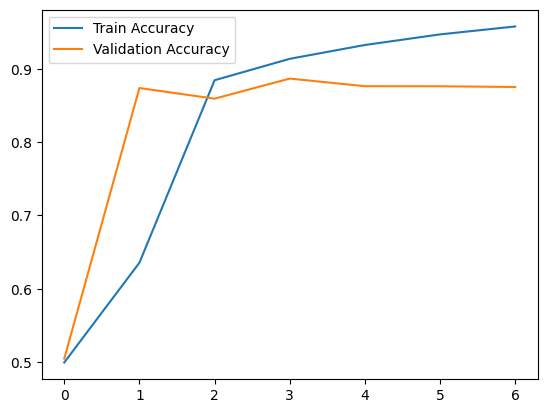

In [20]:
# Reporte de clasificación
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Gráfico de precisión y pérdida
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Conclusión



En este notebook, hemos desarrollado y evaluado un modelo de red neuronal recurrente (LSTM) para la clasificación de sentimientos de reseñas de películas.

Los resultados de la evaluación del modelo en el conjunto de prueba, como se muestra en el reporte de clasificación y la métrica de precisión, indican que el modelo ha logrado un buen desempeño en la tarea de clasificación de sentimientos. Las curvas de precisión de entrenamiento y validación muestran la evolución del rendimiento del modelo durante el entrenamiento.

Este modelo puede ser utilizado para predecir el sentimiento (positivo o negativo) de nuevas reseñas de películas. Para mejorar aún más el rendimiento, se podrían explorar otras arquitecturas de red neuronal, ajustar los hiperparámetros, o utilizar técnicas de preprocesamiento de texto más avanzadas.